# Цель лабораторной работы
Изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.<cite data-cite="ue:lab4"></cite>

# Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
1. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
1. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
1. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
1. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
1. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
1. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
1. Постройте кривые обучения и валидации.

# Выполнение
## Загрузка датасета
Выбранный набор: [Classifying wine varieties](https://www.kaggle.com/brynja/wineuci).

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
# Загрузить набор данных
data = pd.read_csv('Wine.csv', sep=";")
#data = pd.read_csv('train.csv', sep=",")
###data['class'].replace({'seniors':'1','fourth':'0'},inplace=True)
#data['class'] = data['class'].astype('float64')
# Распечать первые 5 строк фрейма данных
data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve,confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Список колонок с типами данных
data.dtypes

Class                             int64
Alcohol                         float64
Malic acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                         int64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                           int64
dtype: object

In [5]:
# Проверим на наличие пустых значений

for col in data.columns:
    print('{} - {}'.format(col, data[data[col].isnull()].shape[0]))

Class - 0
Alcohol - 0
Malic acid - 0
Ash - 0
Alcalinity of ash - 0
Magnesium - 0
Total phenols - 0
Flavanoids - 0
Nonflavanoid phenols - 0
Proanthocyanins - 0
Color intensity - 0
Hue - 0
OD280/OD315 of diluted wines - 0
Proline - 0


In [6]:
data.shape

(178, 14)

## Разделите выборки на обучающую и тестовую

In [7]:
X = data.drop('Class',axis=1).values
y = data['Class'].values
#X = data[['shoe size','height']].values
#y = date['class'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
print('X_train: {}  y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {}  y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (124, 13)  y_train: (124,)
X_test: (54, 13)  y_test: (54,)


## Обучение модели ближайших соседей
Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.

In [8]:
# Setup arrays to store training and test accuracies
neighbors = np.arange(1,14)
len(neighbors)

13

### Обучение при различном количестве соседей

In [9]:
# Вернуть новый массив заданной формы и типа без инициализации записей.
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Настройка классификатора Knn с K соседями
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Обучить модель
    knn.fit(X_train, y_train)
    
    # Вычислить точность на тренировочном наборе
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Вычислить точность на тестовом наборе
    test_accuracy[i] = knn.score(X_test, y_test)

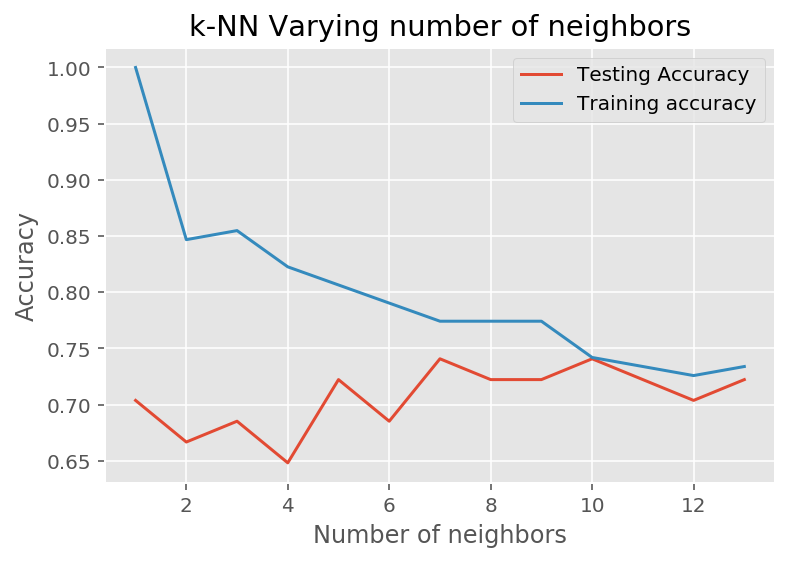

In [10]:
# Построить набор
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

### Изучение работы KNeighborsClassifier

In [11]:
# Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=10)

In [12]:
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [13]:
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,y_test)

0.7407407407407407

In [14]:
#import classification_report
from sklearn.metrics import classification_report

y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.88      0.83      0.86        18
           2       0.88      0.67      0.76        21
           3       0.52      0.73      0.61        15

   micro avg       0.74      0.74      0.74        54
   macro avg       0.76      0.74      0.74        54
weighted avg       0.78      0.74      0.75        54



### Точность

In [15]:
cl1_1 = KNeighborsClassifier(n_neighbors=7)
cl1_1.fit(X_train, y_train)
target1_1 = cl1_1.predict(X_test)
accuracy_score(y_test, target1_1)

0.7407407407407407

### ROC-кривая

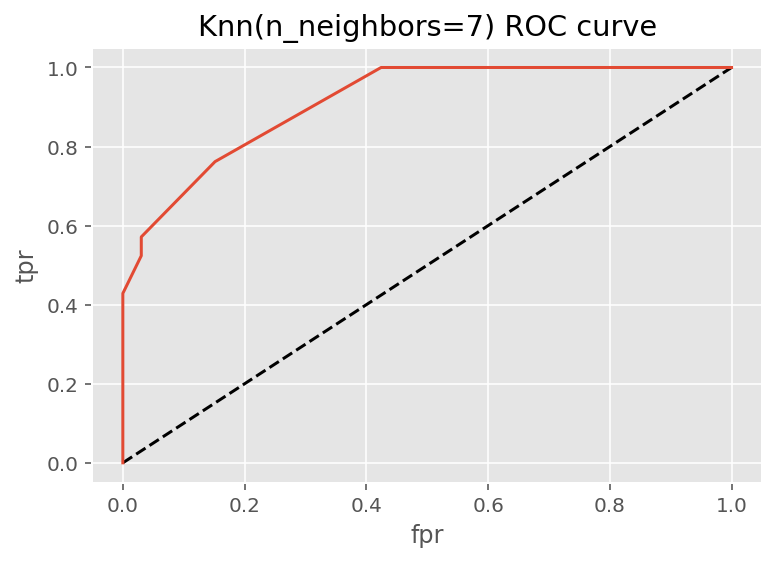

In [16]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=2)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

## Кросс-валидация

In [17]:
param_grid = {'n_neighbors':np.arange(1,14)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
knn_cv.best_score_

0.74193548387096775

In [19]:
knn_cv.best_params_

{'n_neighbors': 4}

### K-fold
Данная стратегия работает в соответствии с определением кросс-валидации.

Каждой стратегии в scikit-learn ставится в соответствии специальный класс-итератор, который может быть указан в качестве параметра cv функций cross_val_score и cross_validate.

In [20]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=4), 
                         X, y, 
                         cv=KFold(n_splits=5))

# Значение метрики accuracy для 5 фолдов
scores

array([ 0.86111111,  0.77777778,  0.61111111,  0.71428571,  0.        ])

In [21]:
# Усредненное значение метрики accuracy для 5 фолдов
np.mean(scores)

0.59285714285714286

In [22]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=4), 
                        X, y, scoring=scoring, 
                        cv=KFold(n_splits=5), return_train_score=True)
scores

{'fit_time': array([ 0.00099683,  0.        ,  0.        ,  0.        ,  0.00101709]),
 'score_time': array([ 0.00301099,  0.00299168,  0.00399208,  0.00299168,  0.00199199]),
 'test_precision': array([ 1.        ,  1.        ,  1.        ,  0.72533333,  0.        ]),
 'train_precision': array([ 0.82446207,  0.80090285,  0.84426486,  0.79604422,  0.87889383]),
 'test_recall': array([ 0.86111111,  0.77777778,  0.61111111,  0.71428571,  0.        ]),
 'train_recall': array([ 0.82394366,  0.8028169 ,  0.84507042,  0.7972028 ,  0.88111888]),
 'test_f1': array([ 0.92537313,  0.86944752,  0.75862069,  0.71080409,  0.        ]),
 'train_f1': array([ 0.82296931,  0.80124489,  0.84424307,  0.7894962 ,  0.87128745])}

### Leave One Out (LOO)
В тестовую выборку помещается единственный элемент (One Out). Количество фолдов в этом случае определяется автоматически и равняется количеству элементов.

Данный метод более ресурсоемкий чем KFold.

Существует эмпирическое правило, что вместо Leave One Out лучше использовать KFold на 5 или 10 фолдов.

In [23]:
loo = LeaveOneOut()
loo.get_n_splits(X)

for train_index, test_index in loo.split(X):
   y_train, y_test = y[train_index], y[test_index]

### Repeated K-Fold

In [24]:
scores2 = cross_val_score(KNeighborsClassifier(n_neighbors=4), 
                         X, y, 
                         cv=RepeatedKFold(n_splits=5, n_repeats=2))
scores2

array([ 0.66666667,  0.61111111,  0.69444444,  0.71428571,  0.6       ,
        0.72222222,  0.61111111,  0.69444444,  0.68571429,  0.71428571])

## Обучение с оптимальным K

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7407407407407407

## Построение кривых обучения

In [26]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\program files (x86)\\microsoft visual studio\\shared\\python36_64\\lib\\site-packages\\matplotlib\\pyplot.py'>

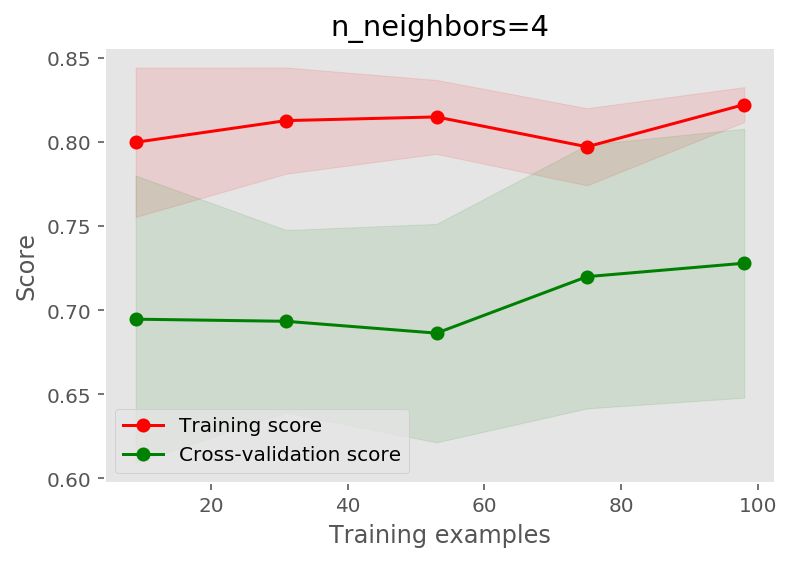

In [27]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=4), 'n_neighbors=4', 
                    X_train, y_train, cv=5)

## Построение кривой валидации

In [28]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\program files (x86)\\microsoft visual studio\\shared\\python36_64\\lib\\site-packages\\matplotlib\\pyplot.py'>

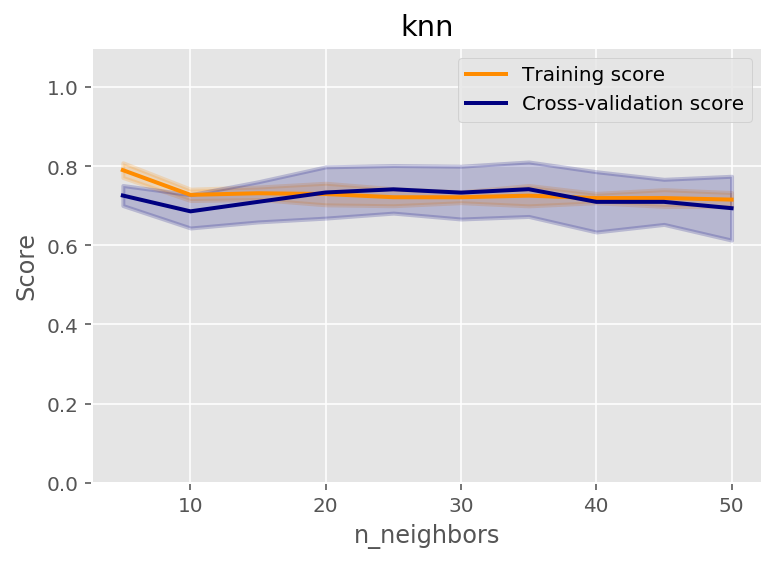

In [29]:
n_range = np.array(range(5,55,5))
plot_validation_curve(KNeighborsClassifier(n_neighbors=4), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=5, scoring="accuracy")